In [1]:
import pyprind
from string import punctuation
import re

In [2]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')

In [4]:
from collections import Counter

In [5]:
counts = Counter()
pbar = pyprind.ProgBar(len(df['review']), \
                       title="단어의 등장 횟수를 카운트합니다.")

단어의 등장 횟수를 카운트합니다.


In [8]:
for i, review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                    for c in review]).lower()
    df.loc[i, 'review'] = text
    pbar.update()
    counts.update(text.split())

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:44


고유한 각 단어를 정수로 매핑하는 dictionary를 만듭니다

In [9]:
word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])

['the', '.', ',', 'and', 'a']


In [17]:
word_to_int = {word: ii for ii, word in \
               enumerate(word_counts, 1)}

In [20]:
mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']), \
                       title="리뷰를 정수로 매핑합니다.")
for review in df['review']:
    mapped_reviews.append([word_to_int[word]  
                           for word in review.split()])
    pbar.update()

리뷰를 정수로 매핑합니다.
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


RNN 구조에 맞도록 동일한 길이의 시퀀스를 만듭니다.
- 시퀀스 길이가 200보다 작으면 왼쪽에 0이 패딩됩니다.
- 시퀀스 킬이가 200보다 크면 마지막 200개 원소만 사용합니다.

In [25]:
sequence_length = 200 # RNN 공식의 T에 해당하는 값
sequences = np.zeros((len(mapped_reviews), sequence_length),
                     dtype=int)
sequences.shape

(50000, 200)

In [27]:
for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

In [28]:
sequences

array([[   0,    0,    0, ...,   31, 1691,    2],
       [1138,    7,    1, ...,   46,  318,    2],
       [   1,  533,    6, ...,   38,  425,    2],
       ...,
       [ 414,   27,  147, ...,  111,   88,    2],
       [  66, 4085, 7775, ...,    2,  807,    2],
       [   0,    0,    0, ...,   10, 1392,    2]])

In [29]:
X_train = sequences[:37500, :]
y_train = df.loc[:37499, 'sentiment'].values
X_test = sequences[37500:, :]
y_test = df.loc[37500:, 'sentiment'].values

In [30]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37500, 200) (37500,) (12500, 200) (12500,)


In [31]:
n_words = len(word_to_int) + 1 # 패딩을 위한 문자 포함
print(n_words)

102967


패딩 문자를 포함한 전체 단어의 수는 102,967개 입니다. 이제 어휘 사전의 인덱스를 훈련 가능한 200차원의 임베딩 행렬로 매핑해보도록 하겠습니다.

In [33]:
from tensorflow.keras import models, layers

In [34]:
model = models.Sequential()
model.add(layers.Embedding(n_words, 200, embeddings_regularizer='l2'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
Total params: 20,593,400
Trainable params: 20,593,400
Non-trainable params: 0
_________________________________________________________________


다음으로 RNN layer를 추가합니다. 긴 시퀀스를 학습하는데 유리한 `tf.keras.layers.LSTM`층을 사용하겠습니다.

In [35]:
model.add(layers.LSTM(16))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 20,607,305
Trainable params: 20,607,305
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])

가장 좋은 검증 점수의 모델 파라미터를 체크포인트로 저장하고 텐서보드를 위한 출력을 지정합니다.

In [38]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [40]:
callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',
                                 monitor='val_loss',
                                 save_best_only=True),
                 TensorBoard(log_dir='sentiment_rnn_logs/{}'.format(
                             time.asctime()))]

이제 모델을 훈련할 단계입니다. 64의 배치 사이즈로 10번의 에포크 동안 훈련하겠습니다. 전체 훈련 세트의 30%를 검증 세트로 사용합니다.

In [41]:
history = model.fit(X_train, y_train,
                    batch_size=64, epochs=10,
                    validation_split=0.3, callbacks=callback_list)

W0921 21:49:33.490019 4531799488 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:353: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26250 samples, validate on 11250 samples
Epoch 1/10
   64/26250 [..............................] - ETA: 5:28 - loss: 172.2957 - acc: 0.4844

W0921 21:49:37.508044 4531799488 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.940318). Check your callbacks.


26250/26250 [==============================] - 161s 6ms/sample - loss: 6.5360 - acc: 0.7063 - val_loss: 0.4551 - val_acc: 0.9022
Epoch 2/10
26250/26250 [==============================] - 156s 6ms/sample - loss: 0.6379 - acc: 0.8226 - val_loss: 0.5313 - val_acc: 0.8706
Epoch 3/10
26250/26250 [==============================] - 157s 6ms/sample - loss: 0.5748 - acc: 0.8472 - val_loss: 0.4888 - val_acc: 0.8751
Epoch 4/10
26250/26250 [==============================] - 155s 6ms/sample - loss: 0.5269 - acc: 0.8645 - val_loss: 0.4633 - val_acc: 0.9316
Epoch 5/10
26250/26250 [==============================] - 155s 6ms/sample - loss: 0.5147 - acc: 0.8707 - val_loss: 0.5055 - val_acc: 0.8756
Epoch 6/10
26250/26250 [==============================] - 154s 6ms/sample - loss: 0.4949 - acc: 0.8781 - val_loss: 0.7099 - val_acc: 0.7453
Epoch 7/10
26250/26250 [==============================] - 157s 6ms/sample - loss: 0.4785 - acc: 0.8856 - val_loss: 0.4183 - val_acc: 0.9112
Epoch 8/10
26250/26250 [=======

fit 메서드에서 반환된 history 객체에서 손실과 정확도를 추출하여 그래프로 그려보겠습니다.

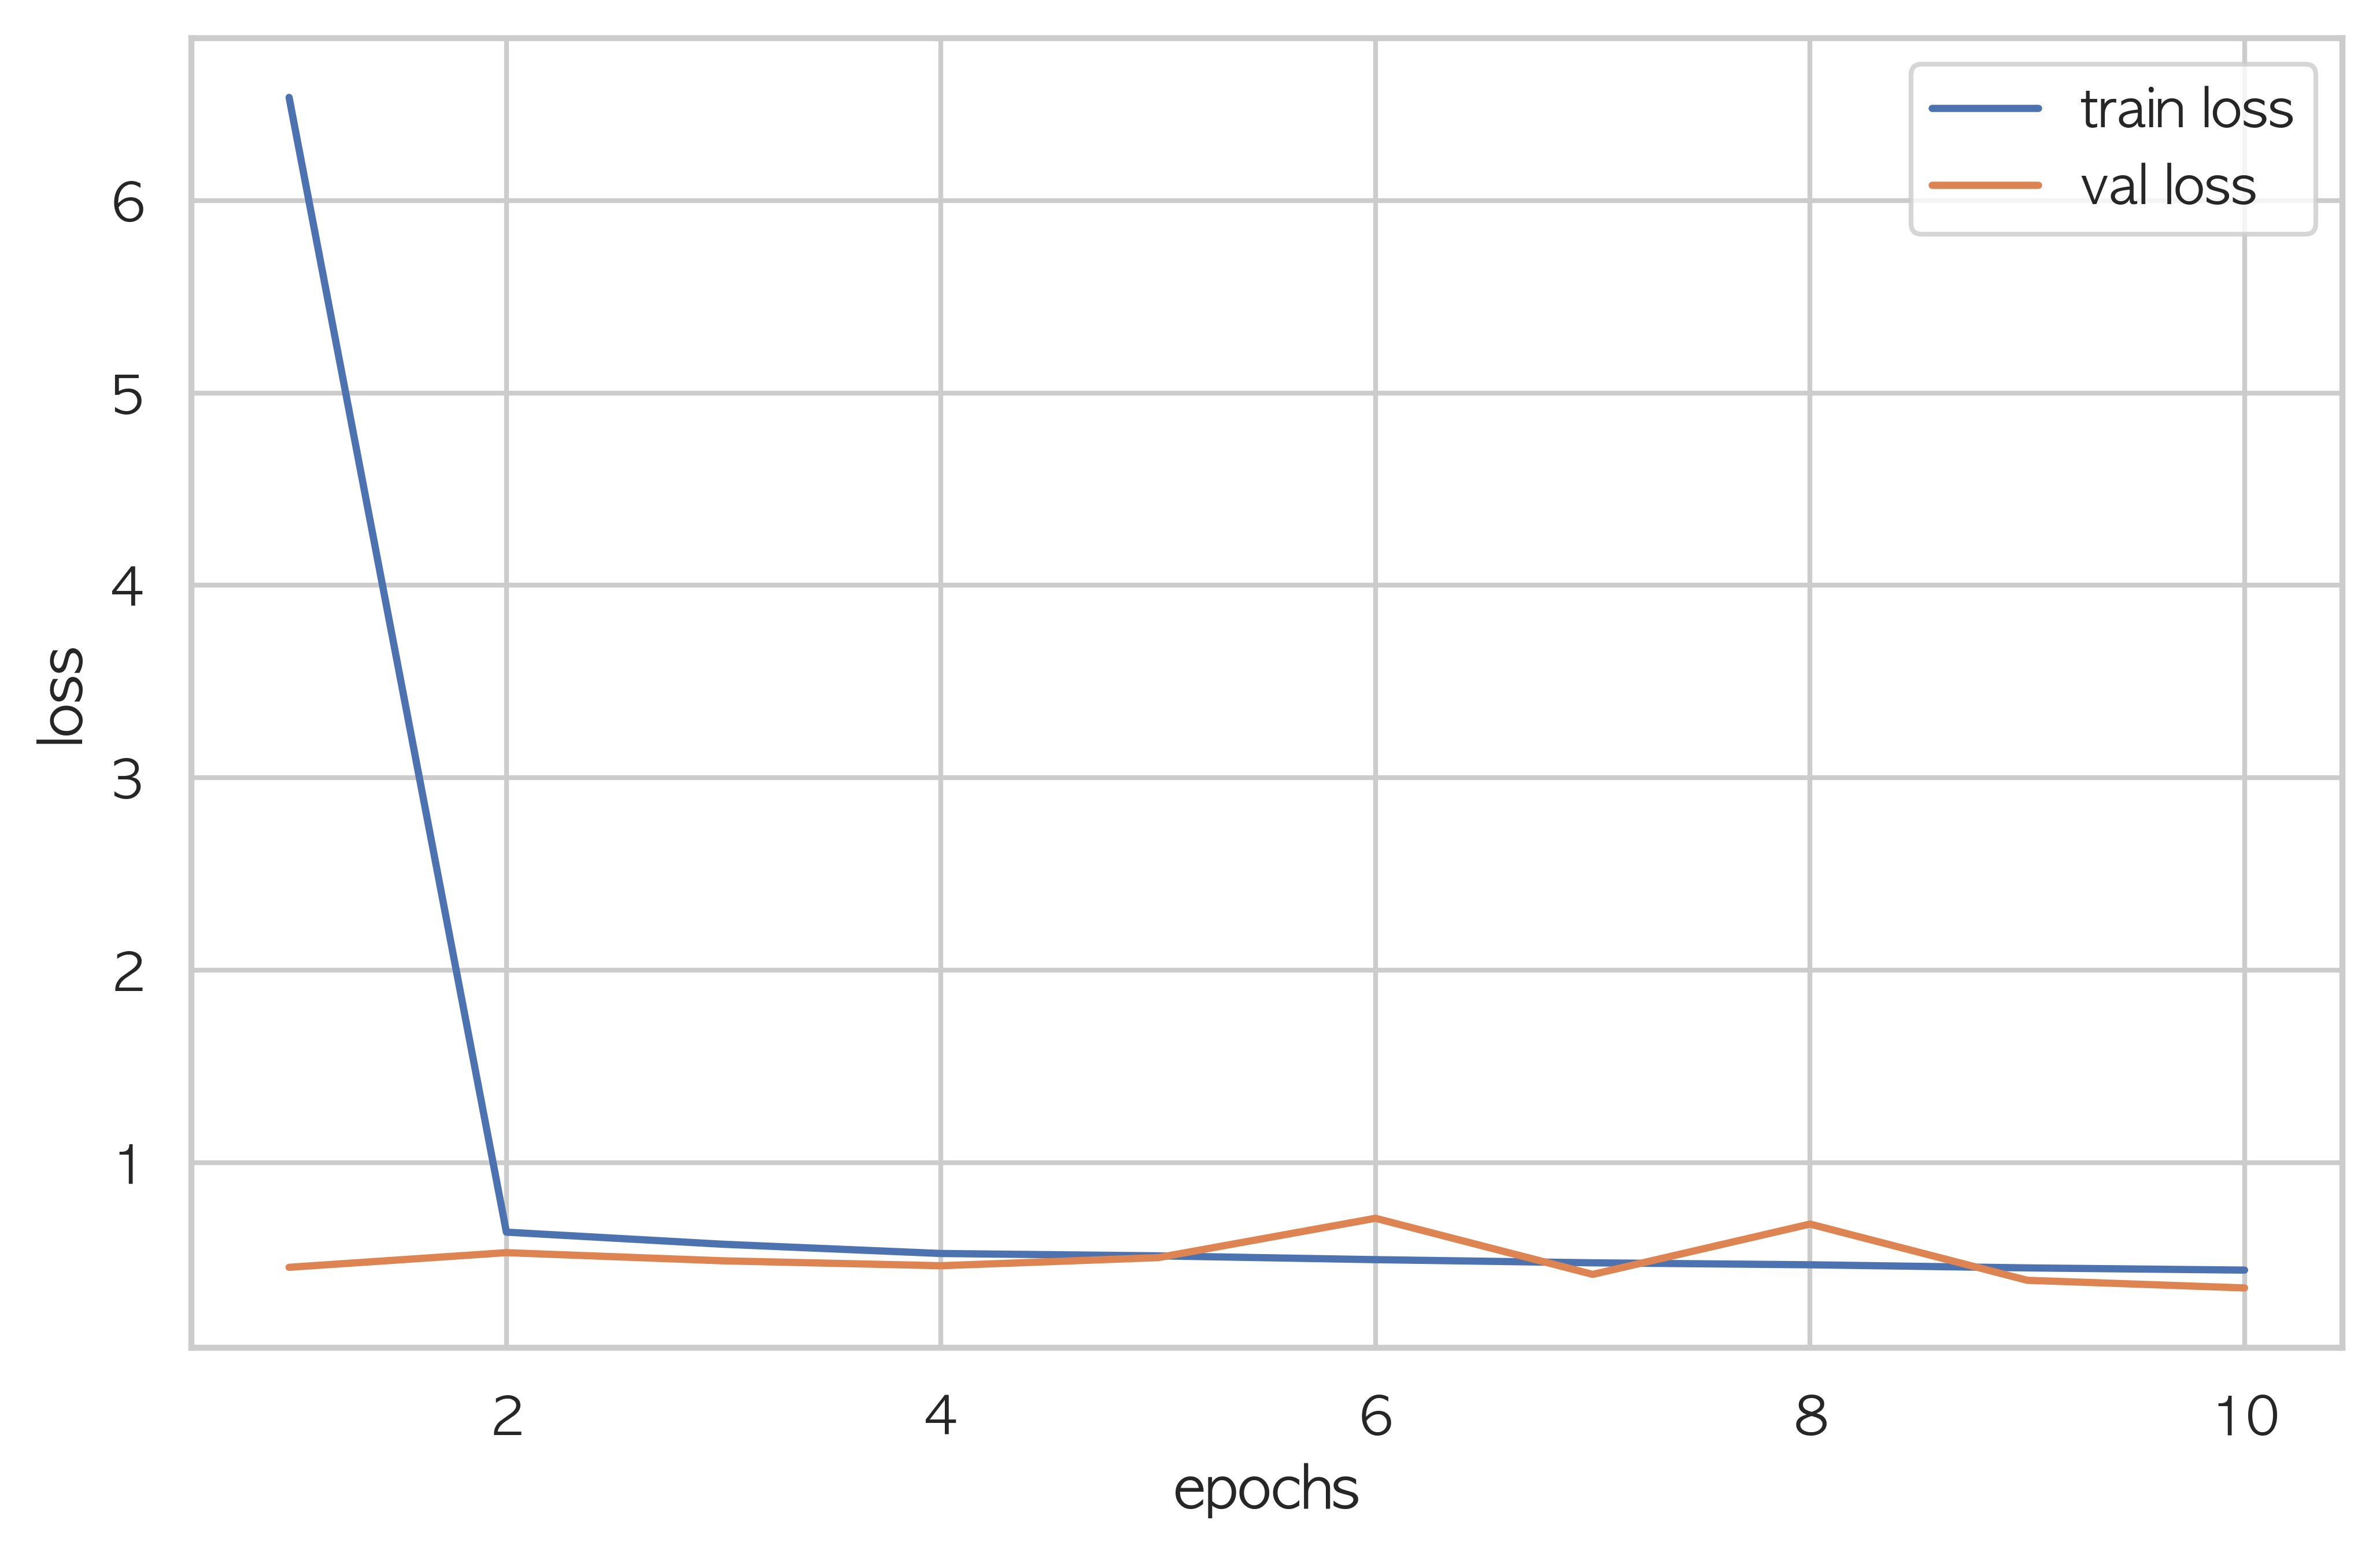

In [50]:
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['loss'], label='train loss')
plt.plot(epochs, history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

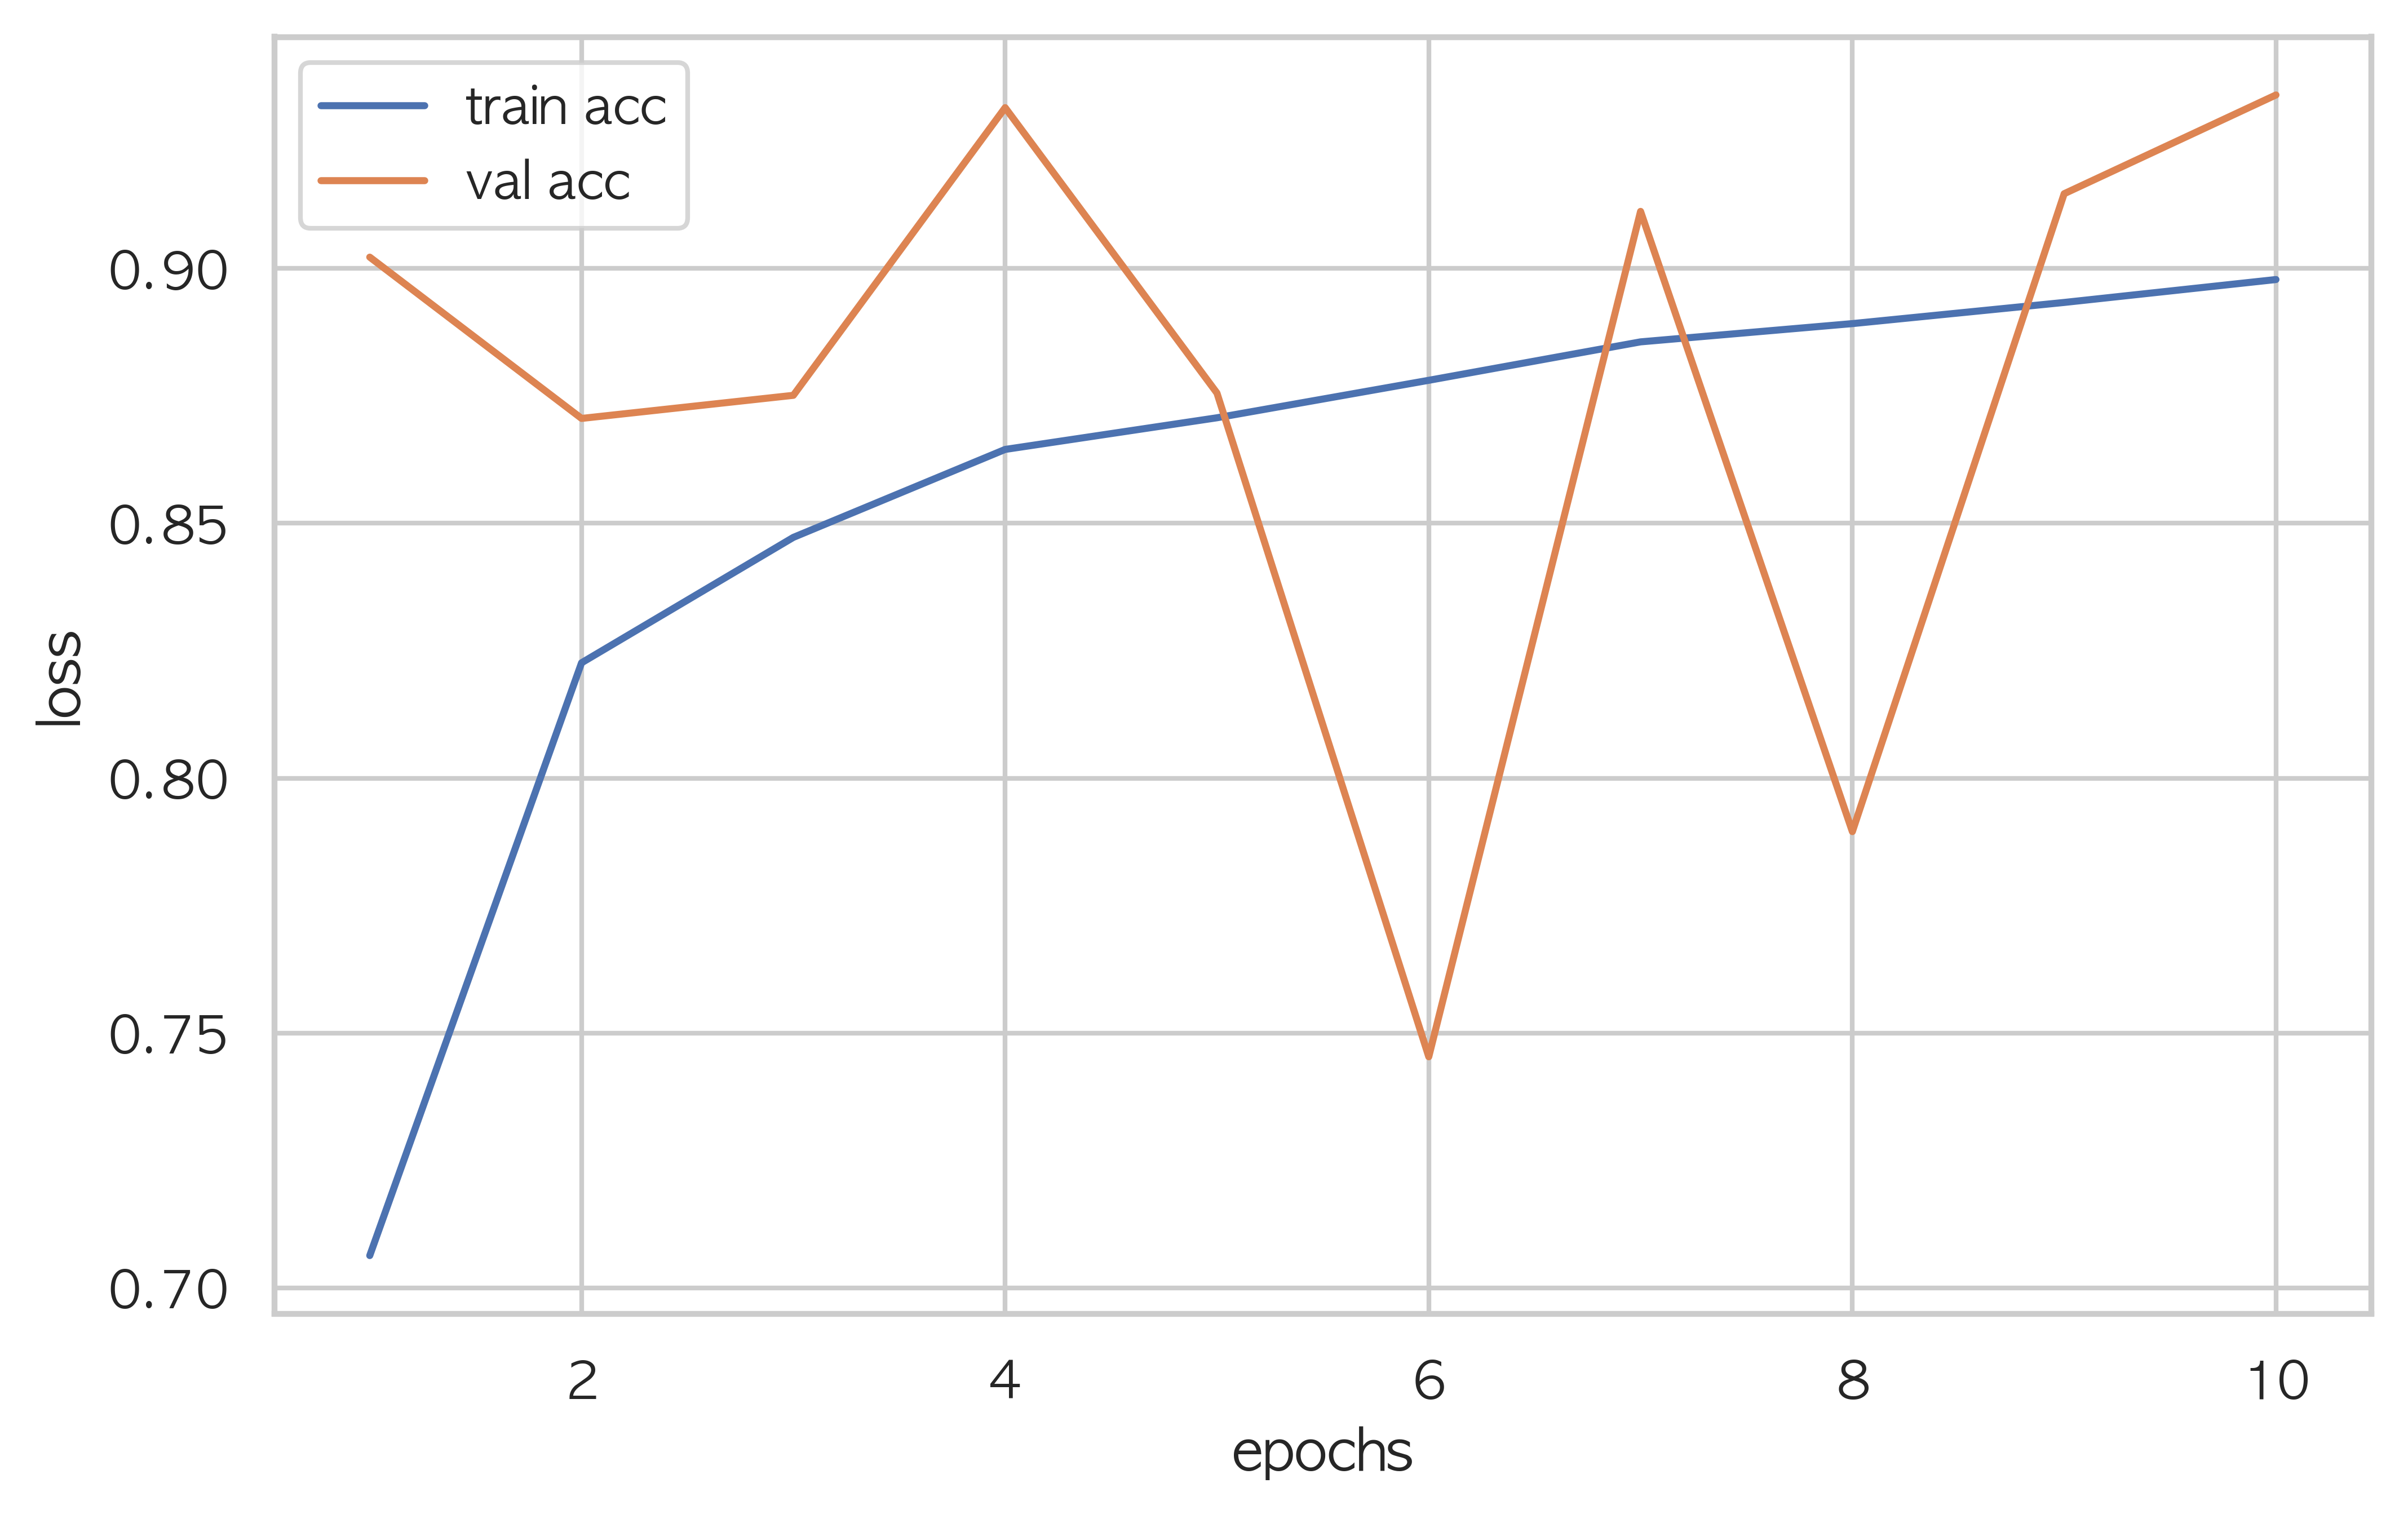

In [51]:
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['acc'], label='train acc')
plt.plot(epochs, history.history['val_acc'], label='val acc')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

개인적 견해: val acc 수치가 다소 불안정한 경향을 보입니다. 이럴 경우 추가적인 하이퍼 파라미터 튜닝이 필요합니다. 지금의 목표는 RNN modeling을 익히는 것이므로 훈련은 여기서 종료하도록 하겠습니다.

이제 훈련 과정에서 만들어진 최상의 체크포인트 파일을 복원하여 테스트 세트에서 성능을 평가합니다.

In [44]:
model.load_weights_weights('sentiment_rnn_checkpoint.h5')
model.evaluate(X_test, y_test)

12500/12500 [==============================] - 29s 2ms/sample - loss: 0.9146 - acc: 0.7449


[0.9145857177734374, 0.74488]

반환된 결과의 첫번째 원소는 손실 점수이며, 두번쩨 원소는 정확도 입니다.

감성분석 결과를 확인하기 위해서 `predict_proba`, `predict_classes` 메서드를 사용할 수 있습니다.

In [45]:
model.predict_proba(X_test[:10])

array([[0.9193641 ],
       [0.00744727],
       [0.460663  ],
       [0.34322315],
       [0.17523935],
       [0.06439894],
       [0.16627818],
       [0.01450339],
       [0.14477558],
       [0.00669851]], dtype=float32)

In [46]:
model.predict_classes(X_test[:10])

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

---